# Linear models

An overview of linear and logistic regression models.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path
from sklearn import metrics

from gwlearn.linear_model import GWLinearRegression, GWLogisticRegression


## Linear regression

Linear regression is a classical example of geographically weighted regression models. In this example, you can predict the number of suicides based on other population data in the [Guerry](https://geodacenter.github.io/data-and-lab//Guerry/) dataset.

In [2]:
gdf = gpd.read_file(get_path("geoda.guerry"))

It is a relatively small dataset covering Frech data from 1800s.

In [3]:
gdf.plot().set_axis_off()

Specify the model and fit the data.

In [4]:
adaptive = GWLinearRegression(
    geometry=gdf.representative_point(),
    bandwidth=25,
    fixed=False,
    kernel='tricube'
)
adaptive.fit(
    gdf[['Crm_prp', 'Litercy', 'Donatns', 'Lottery']],
    gdf["Suicids"],
)

GWLinearRegression(bandwidth=25,
                   geometry=0     POINT (827911.875 2122906.5)
1       POINT (691725.716 2496059)
2     POINT (663520.408 2152677.5)
3       POINT (908864.897 1915755)
4     POINT (916568.259 1968489.5)
                  ...             
80      POINT (322806.903 2192566)
81      POINT (456440.882 2181291)
82     POINT (510125.65 2102842.5)
83      POINT (901963.264 2362015)
84       POINT (697522.96 2318253)
Length: 85, dtype: geometry,
                   kernel='tricube')

You can get a number of outputs from the fitted model. For example, focal predictions (a value is predicted on an observations using the local model fitted around it).

In [5]:
adaptive.pred_

0     65929.297258
1     14289.540382
2     60668.901578
3     25191.170857
4     12777.621045
          ...     
80    41304.669559
81    19766.026593
82    29125.591134
83    25717.441407
84    19381.885833
Length: 85, dtype: float64

This allows you to measure model performance metrics like $R^2$. This value would be comparable to the R2 reported by `mgwr`.

In [6]:
metrics.r2_score(gdf["Suicids"], adaptive.pred_)

0.703052094221075

Local version of $R^2$ is accessible directly.

In [7]:
adaptive.local_r2_

0     0.655274
1     0.564506
2     0.616975
3     0.690529
4     0.704666
        ...   
80    0.444105
81    0.554521
82    0.646275
83    0.174557
84    0.215379
Length: 85, dtype: float64

Any of the values linked to individual observations can then be mapped.

In [8]:
gdf.plot(adaptive.local_r2_, legend=True).set_axis_off()

Similarly, you can access residuals.

In [9]:
gdf.plot(adaptive.resid_, legend=True).set_axis_off()

Each local model then have its own local coefficients.

In [10]:
adaptive.local_coef_

Crm_prp      Litercy   Donatns      Lottery
0   3.147001  -500.570435  0.218349   274.308624
1   2.177315   103.815973  1.276062   -94.396645
2   1.155884 -2112.020365 -7.912018  1015.701421
3   7.945416  -189.098606 -3.969571   132.812885
4   7.575983  -111.394715 -4.221681   107.181855
..       ...          ...       ...          ...
80  0.422307  -769.135891  0.472364   315.564934
81  2.228270  -343.158854  0.233416   242.722924
82  2.319692  -390.456757 -1.543721   356.856559
83  1.918249   147.505689  1.016886   -58.835632
84  0.027807   -92.139088  1.604362   331.684347

[85 rows x 4 columns]

Again, this can be explored visually.

In [11]:
f, axs = plt.subplots(2, 2, figsize=(12, 10))

for column, ax in zip(adaptive.local_coef_.columns, axs.flat):
    gdf.plot(adaptive.local_coef_[column], legend=True, ax=ax)
    ax.set_title(column)
    ax.set_axis_off()

Alongside local coefficients, you can retireve a local intercept value.

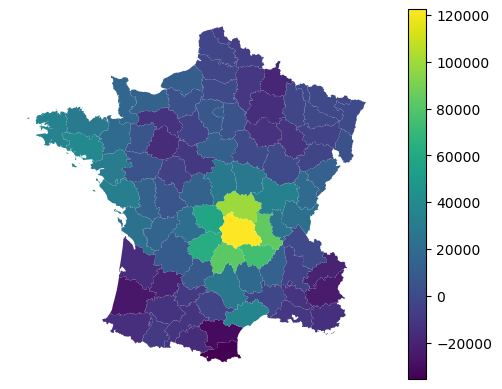

In [12]:
gdf.plot(adaptive.local_intercept_, legend=True).set_axis_off()

## Logistic regression

Due to the nature of the principle in which gwlearn extends scikit-learn, you can also fit the local version of logistic regression for classification tasks. However, there's a caveat. Given it is unlikely that all categories are present in all local models, fitting a non-binary would lead to inconsistent local models. Hence gwlearn currently supports only binary regression, akin to binomial model in `mgwr`.

Let's illustrate it by prediciting whether the number of suicides is over or under median.

In [13]:
y = gdf["Suicids"] > gdf["Suicids"].median()

The API then looks the same, following scikit-learn's model.

In [14]:
binary = GWLogisticRegression(
    geometry=gdf.representative_point(),
    bandwidth=25,
    fixed=False,
    max_iter=500
)
binary.fit(
    gdf[['Crm_prp', 'Litercy', 'Donatns', 'Lottery']],
    y,
)

/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


GWLogisticRegression(bandwidth=25,
                     geometry=0     POINT (827911.875 2122906.5)
1       POINT (691725.716 2496059)
2     POINT (663520.408 2152677.5)
3       POINT (908864.897 1915755)
4     POINT (916568.259 1968489.5)
                  ...             
80      POINT (322806.903 2192566)
81      POINT (456440.882 2181291)
82     POINT (510125.65 2102842.5)
83      POINT (901963.264 2362015)
84       POINT (697522.96 2318253)
Length: 85, dtype: geometry)

Given this is a classification task, we can retrieve probabilites from focal predictions.

In [15]:
binary.proba_

False     True 
0   0.005900  0.994100
1        NaN       NaN
2   0.242553  0.757447
3   0.972850  0.027150
4   0.716931  0.283069
..       ...       ...
80  0.435476  0.564524
81  0.809622  0.190378
82  0.439796  0.560204
83  0.542404  0.457596
84  0.988792  0.011208

[85 rows x 2 columns]

Or their binary counterparts (based on the maximum value).

In [16]:
binary.pred_

0      True
1      <NA>
2      True
3     False
4     False
      ...  
80     True
81    False
82     True
83    False
84    False
Length: 85, dtype: boolean

The regions with missing values are not fitted due to extreme class imbalance in their local context (less than 20% of local `y` values are of a minority class). This is a specific behavior linked to classification models in gwlearn. Rather than simply failing, invariant or extremely imbalanced local `y` does not make the model to fail, it just records the location as skipped. That also means that the location is not used in prediction and for certain locations, there is no possible prediction.

You can check the proportion of local models that exist using `prediction_rate_`.

In [17]:
binary.prediction_rate_

np.float64(0.8705882352941177)

This shows that 87% of focal geometries have their respective models, the rest does not.

For more on dealing with class imbalance, see the [imbalance guide](imbalance.ipynb).

The focal metrics (based on a prediction on a focal geometry using a single local model fitted around that geometry) can be measured using the two outputs shown above.

In [18]:
na_mask = binary.pred_.notna()

metrics.accuracy_score(y[na_mask], binary.pred_[na_mask])

0.9594594594594594

However, you can also extract all data from all local models and use those to measure the performance of the model, rather than using only focal geometries.

The data pooled from all local models are accessible as `y_pooled_` and `pred_pooled_`.

In [19]:
metrics.accuracy_score(binary.y_pooled_, binary.pred_pooled_)

0.7864864864864864

Pooled metrics are typically showing worse results as the distance decay of local observation weights in individual models are playing against a good prediction of values far from the focal point.

Alternatively, you can measure performance metrics per each local model. That is relying on the same pooled data but split to their respective parent local models.

In [20]:
local_accuracy = binary.local_metric(metrics.accuracy_score)
local_accuracy

array([0.64,  nan, 0.84, 0.72, 0.6 , 0.84,  nan, 0.92, 0.84, 0.92,  nan,
       0.8 , 0.96, 0.88, 0.76, 0.84, 0.8 , 0.84, 0.64, 0.6 , 0.8 , 0.88,
       0.56, 0.76, 0.96, 0.88, 0.52, 0.92, 0.8 , 0.8 , 0.92, 0.92, 0.72,
       0.72, 0.6 , 0.72, 0.64, 0.92, 0.64, 0.72, 0.88, 0.76, 0.84,  nan,
       0.88, 0.96, 0.68, 0.8 ,  nan, 0.68, 0.8 , 0.84, 0.88, 0.56, 0.8 ,
       0.8 ,  nan,  nan, 0.88, 1.  , 0.76, 0.92, 0.76, 0.88, 0.76, 0.56,
       0.8 , 0.64, 0.72, 0.72,  nan, 0.96,  nan, 0.88, 0.8 , 0.96,  nan,
        nan, 0.72, 0.76, 0.72, 0.68, 0.76, 0.72, 0.84])

In [21]:
gdf.plot(local_accuracy, legend=True, missing_kwds=dict(color='lightgray')).set_axis_off()

The local coefficients are available as in the regression counterpart.

In [22]:
binary.local_coef_

Crm_prp   Litercy   Donatns   Lottery
0   0.000583  0.032988  0.000678 -0.050549
1        NaN       NaN       NaN       NaN
2   0.001483  0.152063  0.000674  0.199996
3   0.001018 -0.052208  0.000547 -0.010365
4   0.000945  0.008447  0.000280 -0.030962
..       ...       ...       ...       ...
80  0.000411 -0.260107 -0.000190  0.036529
81  0.000255 -0.121968 -0.000161  0.019247
82  0.000182 -0.196829 -0.000244  0.065412
83  0.000462  0.010739  0.000122 -0.008270
84 -0.000173  0.042576  0.000985  0.160625

[85 rows x 4 columns]

Again, this can be explored visually.

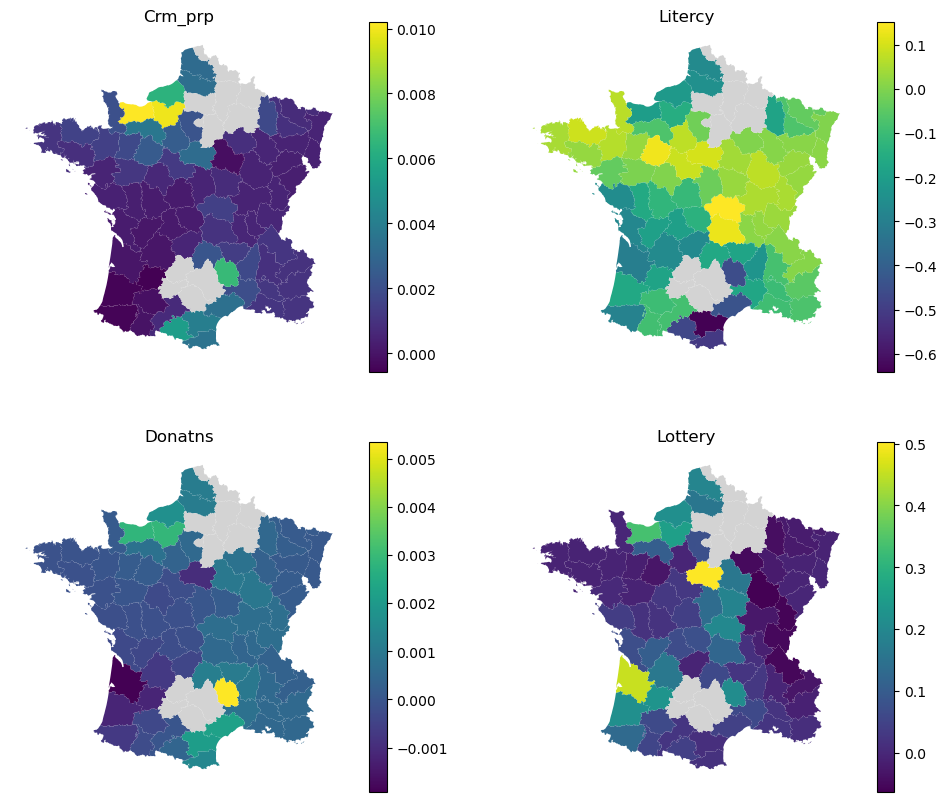

In [23]:
f, axs = plt.subplots(2, 2, figsize=(12, 10))

for column, ax in zip(binary.local_coef_.columns, axs.flat):
    gdf.plot(binary.local_coef_[column], legend=True, ax=ax, missing_kwds=dict(color='lightgray'))
    ax.set_title(column)
    ax.set_axis_off()